In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline  
import sys
sys.path.insert(0,"..")
from model.sequence_prediction import greedy_decode_batch, decode_seq_str, decode_interacively
import pdb
from model.loss import LossCompute
import os
from io_.info_print import printing
from model.seq2seq import LexNormalizer
from model.generator import Generator
from evaluate.interact import interact
MAX_LEN = 20
script_dir = "."

In [2]:
#model_folder_starts_with = "f2f2-batchXdropout_char0.1-to_char_src-1_dir_sent-10_batch_size-model_18_aa04"
#model_folder_starts_with = "f178-DROPOUT_EVEN_INCREASE-0.1-to_sent+word+bridge_out-model_3_046c"
#model_folder_starts_with = "8ce6b-extend_ep-get_True-attention_simplifiedXauxXdropout0.1_scale_aux-True_aux-0.1do_char_dec-True_char_src_atten-model_14_ad6c"
#model_folder_starts_with = "a5c77"
#model_folder_starts_with = "fef8-new_data-batchXdropout_char0-to_char_src-1_dir_sent-10_batch_size-model_2_51a5"
#model_folder_starts_with = "e3900-liu-attention+unrolling0.2-to_char_src-1_dir_sent-15_batch-dir_word_src_1-unrolling_word_True-char_src_attention_False-model_2_14c2"
#model_folder_starts_with = "e3900-liu-attention+unrolling0.2-to_char_src-1_dir_sent-15_batch-dir_word_src_1-unrolling_word_True-char_src_attention_True-model_3_1a3"
#model_folder_starts_with ="8ce6b"
#model_folder_starts_with = "8e628"
#model_folder_starts_with = "84736"
#model_folder_starts_with = "84736-84736-SENT_context-get_True-attention_simplifiedXdrop_out_charXdir_word1dir_word-False_aux-0do_char_dec-True_char_src_atten-model_10_b59b"
#model_folder_starts_with = "84736-84736-SENT_context-get_True-attention_simplifiedXdrop_out_charXdir_word1dir_word-False_aux-0do_char_dec-False_char_src_atten-model_9_bb70"
#model_folder_starts_with = "b9e49-aux_report+dense+ponderatipn+no_bucketing100-dense_dim_auxilliary0.001weight_binary_loss0.2-to_char_src-1_dir_sent-10_batch-dir_word_src_1-unrolling_word_True-char_src_attention_False-model_9_0f05"
#model_folder_starts_with = "97068_rioc-b91d7-aux-again-biggerREPLICATE-replicate1-2dir_word-None_aux-model_19_fb56"
model_folder_starts_with = "97079_rioc-ef365-ATTbest-scale-2-True-25dir_word_encoder-all_context-att2-model_1_cade"
model_folder_starts_with = "97077_rioc-ee386-REP_-replicate1-1dir-scale_1-model_15_f19e"
#model_folder_starts_with = "97147_rioc-6ed16-ATTCONTEXT-with_att-dir_2-X-dropout_bridge0.1-context_word-model_4_76a1"
model_folder_starts_with = "97147_rioc-6ed16-ATTCONTEXT-with_att-dir_2-X-dropout_bridge0.1-context_sent-model_2_7d92"
model_folder_starts_with = "97147_rioc-6ed16-ATTCONTEXT-with_att-dir_2-X-dropout_bridge0.1-context_word-model_4_76a1"

In [3]:
# list all models folder that starts with model_folder_starts_with
list_all_dir = os.listdir("../checkpoints/")
list_ = [dir_ for dir_ in list_all_dir if dir_.startswith(model_folder_starts_with) and not dir_.endswith("log") and not dir_.endswith("summary")]

### Model to interact with 

#### Former models : trained on Liu only , source added as concatanation of word and sentence level as h_0 of decoder , batch size = 10 , small drop out , 

- f2f2-batchXdropout_char0.1-to_char_src-1_dir_sent-10_batch_size-model_18_aa04 : very bad at interacting (NB ; pb of eval)
- f178 also good model trained on liu only 
- 8e628 : attention ; no aux (no bucket , get_batch False ) :  - attention degrades abit the results (still feedin char embedding also)
- e390 + same 24f94 goo : 
    - best is e3900-liu-attention+unrolling0.2-to_char_src-1_dir_sent-15_batch-dir_word_src_1-unrolling_word_True-char_src_attention_False-model_2_14c2 
    - same with attentin but lame : e3900-liu-attention+unrolling0.2-to_char_src-1_dir_sent-15_batch-dir_word_src_1-unrolling_word_True-char_src_attention_True-model_3_1a3f (have to do some code for reloading and visulizing !)

#### New data 
- fef8_new_data : 
- mixed data+ aix test :  8d9a0 + b9e49 to compare bucketing impact at train time 
    - /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/aux_report+dense+ponderatipn+bucketing-last-report-data.html or file:///Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/aux_report+dense+ponderatipn+bucketing-last-report-norm.html
    - /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/aux_report+dense+ponderatipn+no_bucketing-last-report-data.html or file:///Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/8d9a0-auxiililary_true_false.html
    
    
- Auxilliary tuning : best model : b9e49-aux_report+dense+ponderatipn+no_bucketing100-dense_dim_auxilliary0.001weight_binary_loss0.2-to_char_src-1_dir_sent-10_batch-dir_word_src_1-unrolling_word_True-char_src_attention_False-model_9_0f05-folderfile:///Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/aux_report+dense+ponderatipn+no_bucketing-last-report-enriched-auxilliary_task_norm_not_norm-dense_dim_view.html
-

#### Last two ablations with extending epoch + mix data + ablation on auxilliary task ponderation + attention or not  

- 8ce6b-extend_ep... 
    - super lame attention model (from ablation with all context)
    - the other one a bit better   
- a5c77 a bit better but still : no attention much better : cf. plot 

#### Smaller model + liu only 
- 84736 smaller model: still waiting for models : attention not helping 

NB : attention makes training 10 times slower  

In [4]:
#!open /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/ablation_DROPOUT_analysis.html # f178
#!open /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/ablation_DROPOUT_analysis_norm_view.html #f178
#!open /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/ablation_DROPOUT_analysis_2.html # f178 + aaad 

#!open /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/f2f2-batchXdropout_char-summary-norm_view.html
#!open /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/f2f2-batchXdropout_char-summary-data_view.html
# -- 
#!open /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/f2f2_best+01880_reproduction-VAL_TRUE.html
##file:///Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/f2f2-iterate+new_data-norm_view.html (different results with below ? get_batch due ?? )
##/Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/f2f2-batchXdropout_char-summary-norm_view.html 
## diffent from file:///Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/f2f2_best+01880_reproduction-VAL_TRUE.html val True 
#--

#!open /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/liu-attention+unrolling-more-param.html #e390
#!open file:///Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/e390_best+24f9d-VAL_FALSE.html (e390 with Vale False 10 points above!! )

#!open /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/fef8_new_data.html (very good ?)

#!open /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/extend_ep-SENT_context-get_True-attention_simplifiedXauxXdropout-last+bucket_False_eval-get_batch_False.html

#!open /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/8ce6b-extend_ep-get_True-attention_simplifiedXauxXdropout.html

#!open /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/8e628-no_bucketing-get_batch_False-train-attention-last+bucket_False_eval-get_batch_False-report.json.html



--------------------------------Interatcing with new model--------------------------------
 97147_rioc-6ed16-ATTCONTEXT-with_att-dir_2-X-dropout_bridge0.1-context_word-model_4_76a1 


Loading dictionary from ./../checkpoints/97147_rioc-6ed16-ATTCONTEXT-with_att-dir_2-X-dropout_bridge0.1-context_word-model_4_76a1-folder/dictionaries 
Character vocabulary is 109 length
Loading model with argument {'auxilliary_arch': {'weight_binary_loss': None, 'auxilliary_task_norm_not_norm-dense_dim_2': 0, 'auxilliary_task_norm_not_norm-dense_dim': 0, 'auxilliary_task_norm_not_norm': False}, 'output_dim': 200, 'hidden_size_encoder': 400, 'batch_size': 25, 'hidden_size_decoder': 400, 'char_embedding_dim': 50, 'decoder_arch': {'unrolling_word': True, 'char_src_attention': True, 'cell_word': 'LSTM', 'dir_word': 'uni', 'teacher_force': False, 'drop_out_char_embedding_decoder': 0.2, 'cell_sentence': 'none', 'drop_out_word_decoder_cell': 0.0}, 'hidden_size_sent_encoder': 200, 'gradient_clipping': 1, 'voc_s

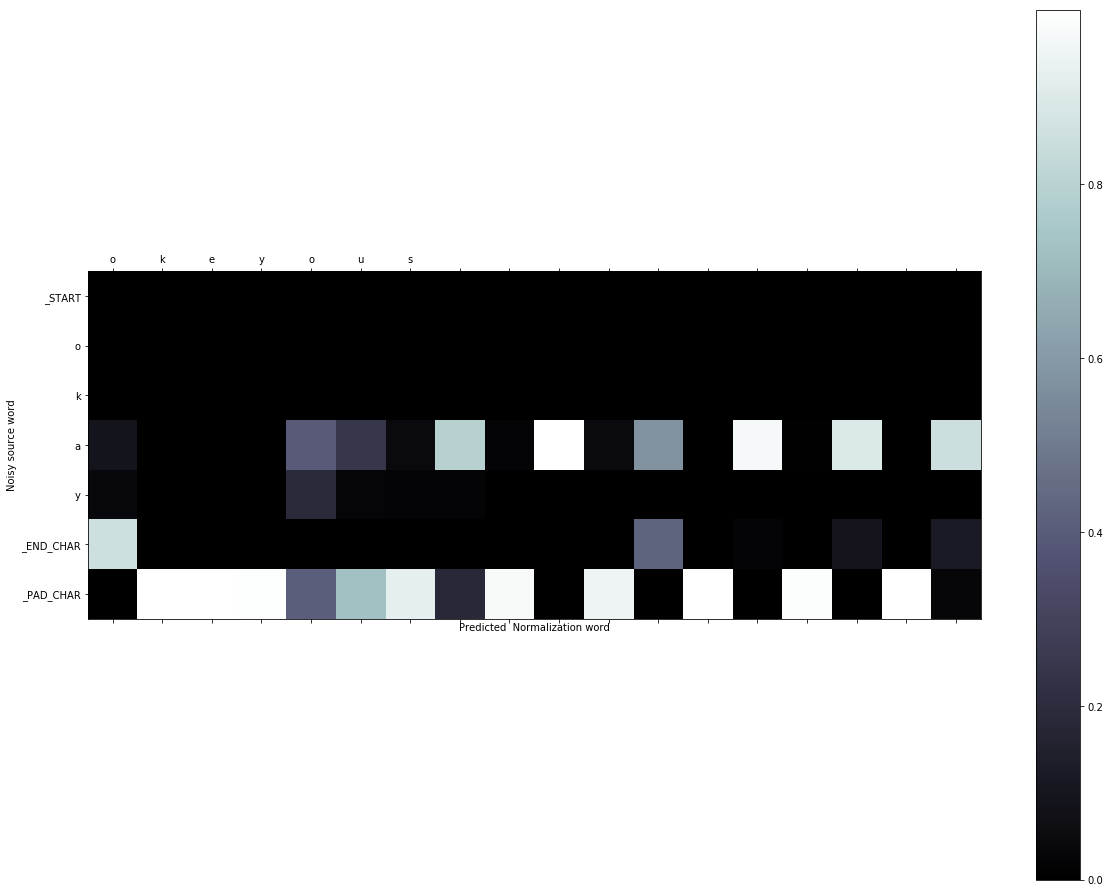

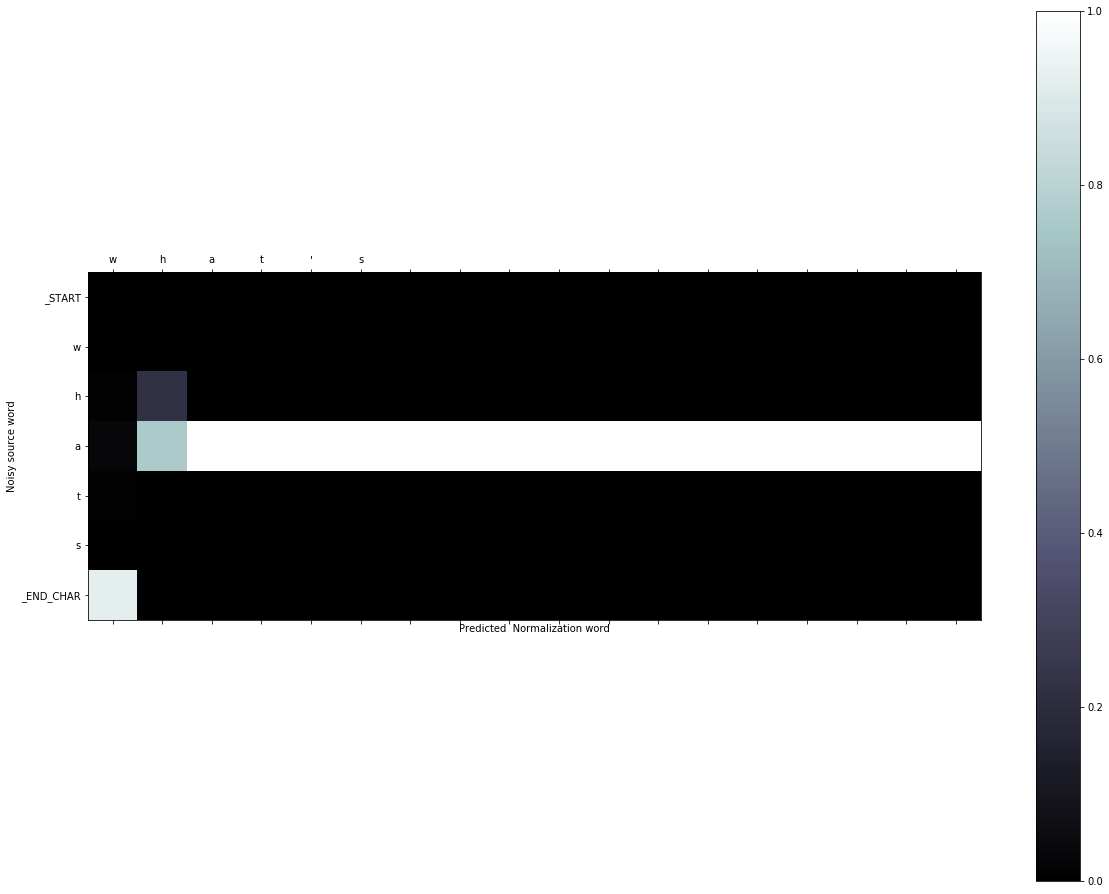

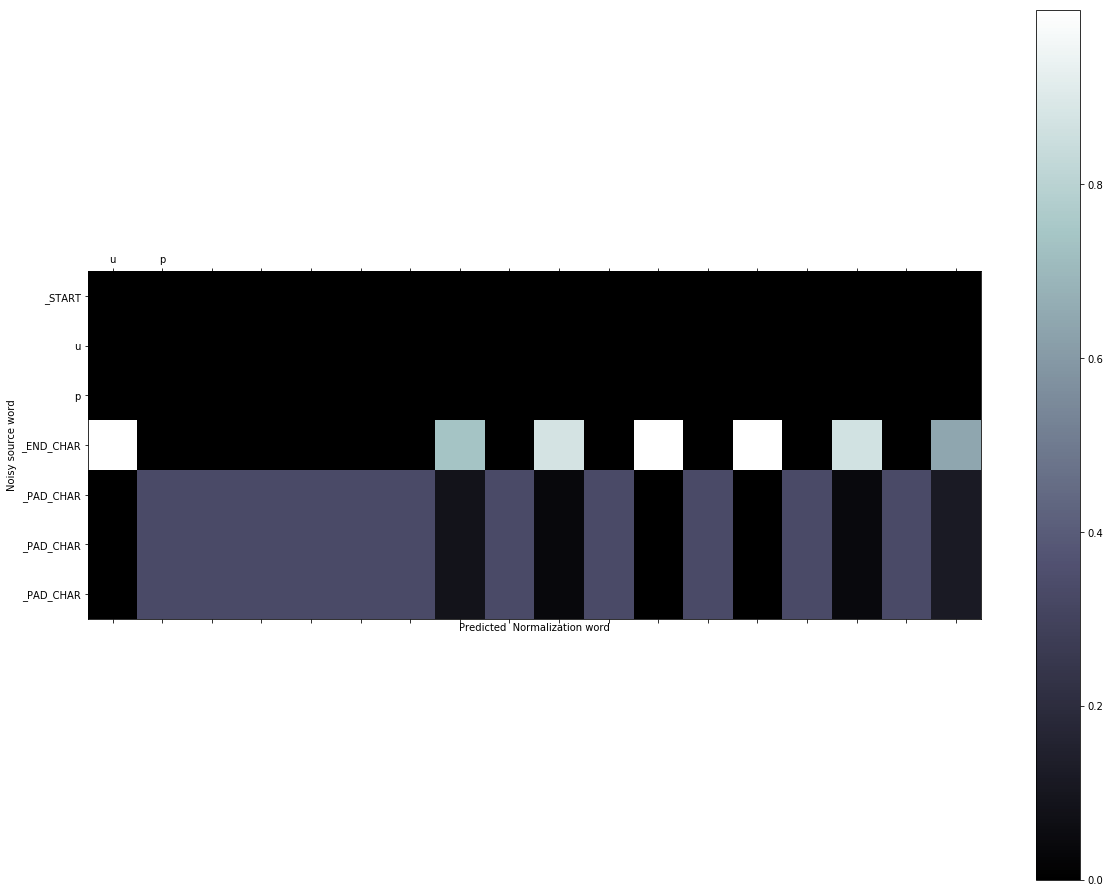

DECODED text is : ['okeyous', "what's", 'up'] original is ['okay', 'whats', 'up']


In [ ]:
for folder_name in list_:
    assert len(list_)>0, "list empty"
    model_full_name = folder_name[:-7]
    print("\n\n--------------------------------Interatcing with new model--------------------------------\n", model_full_name,"\n\n")
    dic_path = os.path.join(script_dir, "..", "checkpoints", model_full_name + "-folder", "dictionaries")
    model_dir = os.path.join(script_dir, "..", "checkpoints", model_full_name + "-folder")
    interact(dic_path=dic_path, dir_model=model_dir, model_full_name=model_full_name, debug=False, 
             show_attention=False,verbose=0,
             save_attention=False)
    #break

## Comments
- on model 97077_rioc-ee386-REP_-replicate1-1dir-scale_1-model_15_f19e with auxilliary task no attention quite small model
    - interesting case : 
        - my normalized to tomorrow : probably bcause of 2mor --> tommorow 
    - very lame at decoding very short word ? 
- 97147_rioc-6ed16-ATTCONTEXT-with_att-dir_2-X-dropout_bridge0.1-context_word-model_4_76a1
    - attention is not static --> but no clear trend
    - interetsintgly with same model but only using sent context : the attention focus on last word all the time "97147_rioc-6ed16-ATTCONTEXT-with_att-dir_2-X-dropout_bridge0.1-context_sent-model_2_7d92" 